# MNIST Veri Seti ile TensorFlow Modeli Eğitimi

Bu dokümantasyon, MNIST veri seti kullanarak ileri düzey bir sinir ağı pipeline modeli oluşturmak ve eğitmek için TensorFlow ve TensorFlow Datasets kullanımını açıklamaktadır.

## İçerik

1. [Gerekli Kütüphanelerin İçe Aktarılması](#scrollTo=s_A2f-RnDwBQ)
2. [Veri Setinin Yüklenmesi](#scrollTo=ERqMvKV7Tfg_)
3. [Görüntü Normalleştirme Fonksiyonu](#scrollTo=k2VbaAVMTmKa)
4. [Eğitim Veri Setinin Hazırlanması](#scrollTo=a6FyL8wjTsWI)
5. [Test Veri Setinin Hazırlanması](#scrollTo=iXgUhEX5Tzpl)
6. [Model Mimarisi](#scrollTo=u50Sh9pBT87s)
7. [Model Derleme](#scrollTo=WRP7Q1SgUCHJ)
8. [Model Eğitimi](#scrollTo=rfCUM_JjUIk7)
9. [Optimizer ve Regularization Teknikleri](#scrollTo=VrF_tHskOIKd)
10. [Test Sonuçları](#scrollTo=0v6xMe1dPREo)
11. [Batch Normalizasyonu ve Daha Derin Sinir Ağı](#scrollTo=bd2HL0k85LiF)
12. [MNIST Modelleme: Rapor ve Analiz](#scrollTo=NbCNWk0d9rzz)



## Gerekli Kütüphanelerin İçe Aktarılması

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

Bu satırlar, TensorFlow ve TensorFlow Datasets kütüphanelerini projeye dahil eder. TensorFlow, derin öğrenme modellerini oluşturmak ve eğitmek için kullanılırken, TensorFlow Datasets ise hazır veri setlerine erişim sağlar.

## Veri Setinin Yüklenmesi

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Bu kod bloğu:
- MNIST veri setini yükler (el yazısı rakamlardan oluşan klasik bir veri seti)
- Veri setini eğitim ve test olarak iki parçaya ayırır
- Dosyaları karıştırır (`shuffle_files=True`)
- Veri setini denetimli öğrenme formatında alır (`as_supervised=True`), bu (görüntü, etiket) çiftleri sağlar
- Veri seti hakkında ek bilgiler içeren `ds_info` nesnesini döndürür

## Görüntü Normalleştirme Fonksiyonu

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

Bu fonksiyon:
- Görüntü piksel değerlerini 0-255 aralığından 0-1 aralığına dönüştürür
- Görüntü tipini `uint8`'den `float32`'ye dönüştürür
- Etiket değerlerini değiştirmeden bırakır

## Eğitim Veri Setinin Hazırlanması

In [4]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


Bu adımlar eğitim veri setini optimum performans için hazırlar:
1. Tüm görüntülere normalleştirme işlemi uygular (paralel olarak)
2. Veri setini önbelleğe alır, böylece her epoch'ta yeniden yüklenmesi gerekmez
3. Eğitim örneklerini karıştırır, her epoch için farklı sırada sunar
4. 128 örneklik gruplar (batch) oluşturur
5. Prefetch işlemiyle bir sonraki veri grubunu hazır bulundurarak eğitim sürecini hızlandırır

## Test Veri Setinin Hazırlanması

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Test veri seti de benzer şekilde hazırlanır, ancak karıştırma işlemi uygulanmaz çünkü test sırasında verinin sırası önemli değildir.

## Model Mimarisi

In [6]:
model_adam = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Bu kod, sıralı (Sequential) bir model oluşturur:
1. İlk katman: 28x28 boyutlu 2D görüntüleri düzleştirerek 1D vektörlere (784 boyutlu) dönüştürür
2. Gizli katman: 128 nöronlu ve ReLU aktivasyon fonksiyonlu tam bağlantılı (Dense) katman
3. Çıkış katmanı: 10 nöronlu tam bağlantılı katman (0-9 rakamları için, aktivasyon fonksiyonu yok)

## Model Derleme

In [7]:
model_adam.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Bu kod modeli eğitim için yapılandırır:
1. Optimizer: 0.001 öğrenme oranına sahip Adam optimizer
2. Kayıp fonksiyonu: Sparse Categorical Crossentropy (logits modunda, yani softmax uygulanmadan)
3. Metrik: Sparse Categorical Accuracy, modelin doğruluk oranını izlemek için

## Model Eğitimi
### Adam Optimizer Kullanılan Model

In [8]:
history_adam = model_adam.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8294 - loss: 0.6229 - val_accuracy: 0.9471 - val_loss: 0.1898
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9491 - loss: 0.1779 - val_accuracy: 0.9615 - val_loss: 0.1305
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9661 - loss: 0.1217 - val_accuracy: 0.9694 - val_loss: 0.1042
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9735 - loss: 0.0926 - val_accuracy: 0.9717 - val_loss: 0.0974
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9776 - loss: 0.0777 - val_accuracy: 0.9738 - val_loss: 0.0888
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9821 - loss: 0.0613 - val_accuracy: 0.9764 - val_loss: 0.0785




**Özellikler:**
- Öğrenme oranı: 0.001
- Optimizer: Adam
- Gizli katman boyutu: 128 nöron
- Aktivasyon fonksiyonu: ReLU

## Optimizer ve Regularization Teknikleri

### SGD Optimizer Kullanılan Model

In [9]:
model_sgd = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

model_sgd.compile(
    optimizer=tf.keras.optimizers.SGD(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_sgd = model_sgd.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5488 - loss: 1.6324 - val_accuracy: 0.8532 - val_loss: 0.6480
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8561 - loss: 0.6048 - val_accuracy: 0.8859 - val_loss: 0.4606
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8773 - loss: 0.4636 - val_accuracy: 0.8954 - val_loss: 0.3956
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8901 - loss: 0.4033 - val_accuracy: 0.9025 - val_loss: 0.3611
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8977 - loss: 0.3692 - val_accuracy: 0.9065 - val_loss: 0.3381
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9028 - loss: 0.3475 - val_accuracy: 0.9100 - val_loss: 0.3222


**Özellikler:**
- Öğrenme oranı: 0.01
- Optimizer: Stochastic Gradient Descent (SGD)
- Gizli katman boyutu: 128 nöron
- Aktivasyon fonksiyonu: ReLU

###  Dropout Eklenmiş Model

In [10]:
model_dropout = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10)
])

model_dropout.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_dropout = model_dropout.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7593 - loss: 0.7937 - val_accuracy: 0.9348 - val_loss: 0.2207
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9199 - loss: 0.2787 - val_accuracy: 0.9539 - val_loss: 0.1588
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9377 - loss: 0.2192 - val_accuracy: 0.9609 - val_loss: 0.1327
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9453 - loss: 0.1894 - val_accuracy: 0.9683 - val_loss: 0.1135
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9483 - loss: 0.1720 - val_accuracy: 0.9689 - val_loss: 0.1065
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9540 - loss: 0.1549 - val_accuracy: 0.9701 - val_loss: 0.0998


**Özellikler:**
- Öğrenme oranı: 0.001
- Optimizer: Adam
- Gizli katman boyutu: 128 nöron
- Dropout oranı: 0.5 (eğitim sırasında nöronların %50'si devre dışı bırakılır)
- Aktivasyon fonksiyonu: ReLU

## Test Sonuçları

In [11]:
test_results = {
    'Adam': model_adam.evaluate(ds_test, verbose=0),
    'SGD': model_sgd.evaluate(ds_test, verbose=0),
    'Dropout': model_dropout.evaluate(ds_test, verbose=0)
}

print("\n\nKarşılaştırma Sonuçları:")
print(f"{'Model':<10} {'Test Kaybı':<10} {'Test Doğruluğu':<15}")
print("-"*35)
for model_name, (loss, acc) in test_results.items():
    print(f"{model_name:<10} {loss:<10.4f} {acc:<15.4f}")



Karşılaştırma Sonuçları:
Model      Test Kaybı Test Doğruluğu 
-----------------------------------
Adam       0.0785     0.9764         
SGD        0.3222     0.9100         
Dropout    0.0998     0.9701         


### Grafik üzerinde overfitting analizi

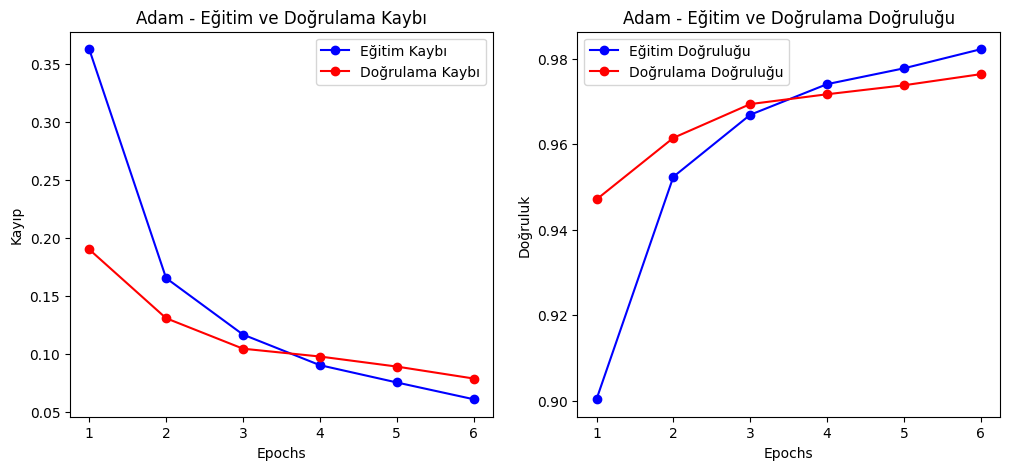

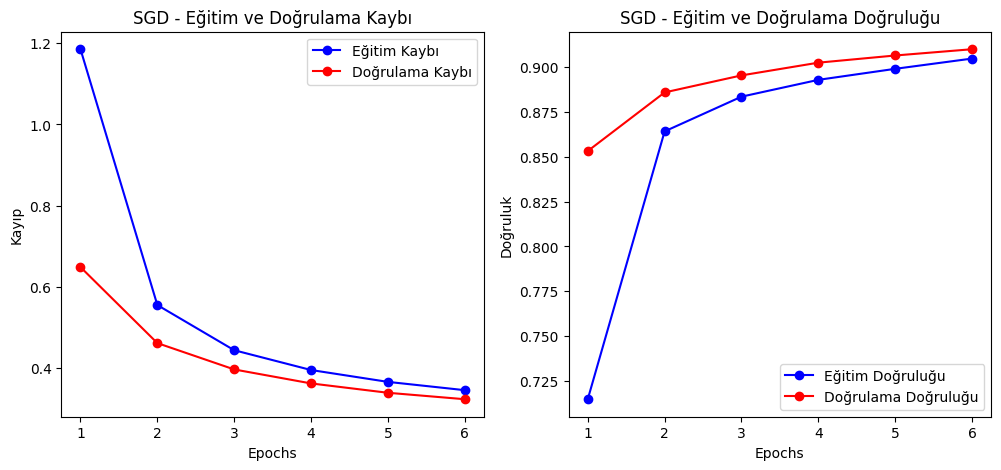

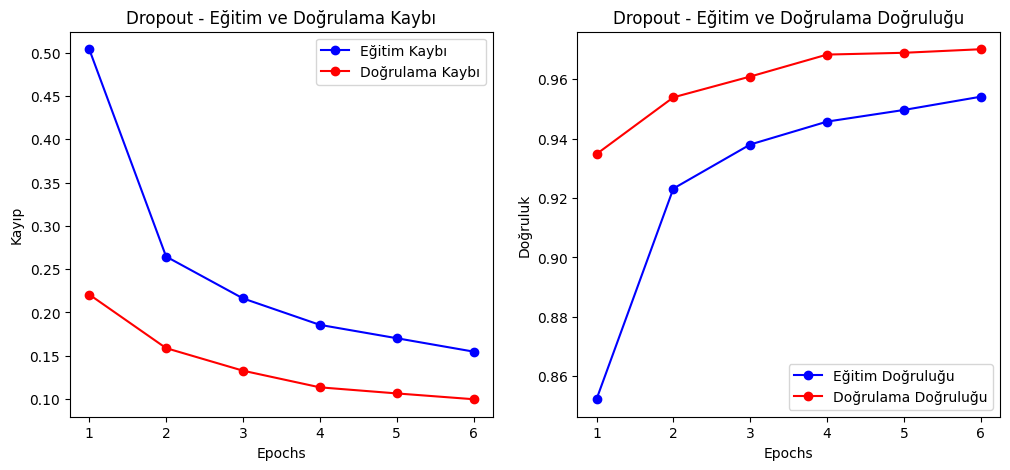

In [12]:
import matplotlib.pyplot as plt

history_data = {
    "Adam": history_adam.history,
    "SGD": history_sgd.history,
    "Dropout": history_dropout.history
}

# Grafik çizme fonksiyonu
def plot_overfitting_analysis(history_dict, model_name):
    epochs = range(1, len(history_dict['loss']) + 1)

    # loss grafiği
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo-', label='Eğitim Kaybı')
    plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Doğrulama Kaybı')
    plt.xlabel('Epochs')
    plt.ylabel('Kayıp')
    plt.title(f'{model_name} - Eğitim ve Doğrulama Kaybı')
    plt.legend()

    # accuracy grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Eğitim Doğruluğu')
    plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.title(f'{model_name} - Eğitim ve Doğrulama Doğruluğu')
    plt.legend()

    plt.show()

# Her model için overfitting analizi grafiği çizme
for model_name, history in history_data.items():
    plot_overfitting_analysis(history, model_name)




*   **Grafiklere bakarak dropout yönteminin en istikrarlı olduğunu söyleyebiliriz**
*   **Daha farklı yöntemler deniyelim. Batch normalizasyon ve daha derin bir sinir ağı ile eğitim yapıp sonuçları inceleyelim**

## Batch Normalizasyonu ve Daha Derin Sinir Ağı

In [15]:
# Batch Normalizasyonlu Model
model_batchnorm = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10)
])

model_batchnorm.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("\n4. Batch Normalizasyon ile Eğitim:")
history_batchnorm = model_batchnorm.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)


4. Batch Normalizasyon ile Eğitim:
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8797 - loss: 0.4027 - val_accuracy: 0.9549 - val_loss: 0.1442
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9680 - loss: 0.1086 - val_accuracy: 0.9717 - val_loss: 0.1000
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9799 - loss: 0.0697 - val_accuracy: 0.9735 - val_loss: 0.0878
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9862 - loss: 0.0521 - val_accuracy: 0.9743 - val_loss: 0.0826
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9881 - loss: 0.0392 - val_accuracy: 0.9765 - val_loss: 0.0790
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9901 - loss: 0.0325 - val_accuracy: 0.9770 - val_loss: 0.0753


In [16]:
# Daha Gelişmiş Batch Normalizasyonlu Model (Dropout ile birlikte)
model_batchnorm_dropout = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model_batchnorm_dropout.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("\n5. Batch Normalizasyon + Dropout ile Eğitim:")
history_batchnorm_dropout = model_batchnorm_dropout.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)


5. Batch Normalizasyon + Dropout ile Eğitim:
Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8190 - loss: 0.5963 - val_accuracy: 0.9535 - val_loss: 0.1481
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9418 - loss: 0.1936 - val_accuracy: 0.9643 - val_loss: 0.1103
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9546 - loss: 0.1521 - val_accuracy: 0.9718 - val_loss: 0.0931
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9597 - loss: 0.1324 - val_accuracy: 0.9698 - val_loss: 0.0974
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9663 - loss: 0.1134 - val_accuracy: 0.9729 - val_loss: 0.0877
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9688 - loss: 0.1053 - val_accuracy: 0.9768 - val_loss: 0.0772




Güncellenmiş Karşılaştırma Sonuçları:
Model                Test Kaybı Test Doğruluğu 
---------------------------------------------
Adam                 0.0785     0.9764         
SGD                  0.3222     0.9100         
Dropout              0.0998     0.9701         
BatchNorm            0.0753     0.9770         
BatchNorm+Dropout    0.0772     0.9768         


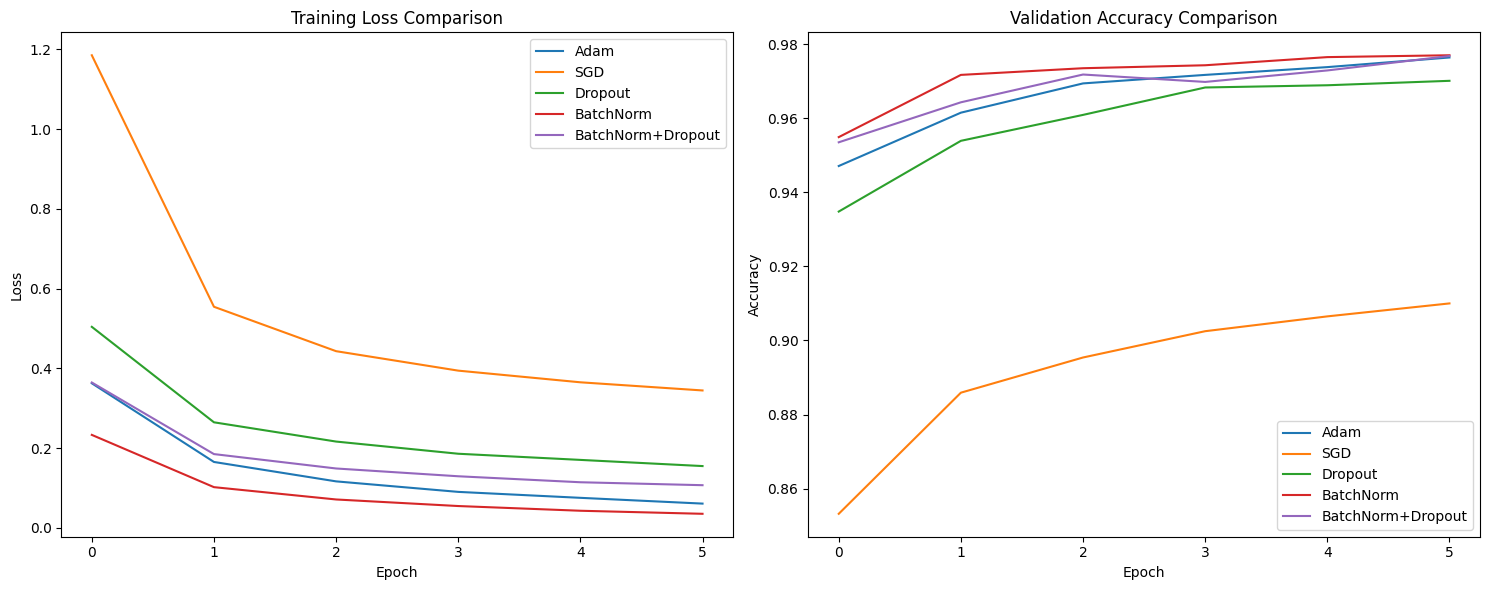

In [17]:
test_results['BatchNorm'] = model_batchnorm.evaluate(ds_test, verbose=0)
test_results['BatchNorm+Dropout'] = model_batchnorm_dropout.evaluate(ds_test, verbose=0)

print("\n\nGüncellenmiş Karşılaştırma Sonuçları:")
print(f"{'Model':<20} {'Test Kaybı':<10} {'Test Doğruluğu':<15}")
print("-"*45)
for model_name, (loss, acc) in test_results.items():
    print(f"{model_name:<20} {loss:<10.4f} {acc:<15.4f}")


# Görselleştirme
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history_adam.history['loss'], label='Adam')
plt.plot(history_sgd.history['loss'], label='SGD')
plt.plot(history_dropout.history['loss'], label='Dropout')
plt.plot(history_batchnorm.history['loss'], label='BatchNorm')
plt.plot(history_batchnorm_dropout.history['loss'], label='BatchNorm+Dropout')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_adam.history['val_accuracy'], label='Adam')
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.plot(history_dropout.history['val_accuracy'], label='Dropout')
plt.plot(history_batchnorm.history['val_accuracy'], label='BatchNorm')
plt.plot(history_batchnorm_dropout.history['val_accuracy'], label='BatchNorm+Dropout')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Yorumlama
*  **Batch Normalization tekniğinin kullanımı, model performansında belirgin iyileşme sağlamıştır.**

*   **Adam optimizasyon algoritması, SGD'ye göre daha hızlı yakınsama ve daha iyi sonuçlar üretmiştir.**

*   **Regularization teknikleri (Dropout ve BatchNorm), modellerin genelleme yeteneğini artırmıştır.**
*   **En düşük performans SGD ile elde edilirken, en yüksek doğruluk BatchNorm kullanan modellerde gözlemlenmiştir.**

# MNIST Modelleme: Rapor ve Analiz

## 1. Model Mimarisi ve Sonuçlar

Dokümanınızda, MNIST veri seti üzerinde çeşitli mimari ve tekniklerle oluşturulan beş farklı model

### Temel Mimariler
Tüm modeller temel olarak şu katmanlardan oluşuyor:
- **Girdi Katmanı**: 28×28 piksel (784 boyutlu düzleştirilmiş vektör)
- **Gizli Katman(lar)**: İlk dört model için tek gizli katman (128 nöron), son model için iki gizli katman (128 ve 64 nöron)
- **Çıkış Katmanı**: 10 nöron (0-9 rakamları için)

### Modeller ve Sonuçları

| Model | Optimizasyon | Regularization | Test Kaybı | Test Doğruluğu |
|-------|--------------|-----------------|------------|----------------|
| Adam | Adam (lr=0.001) | Yok | 0.0785  | 0.9764 |
| SGD | SGD (lr=0.01) | Yok | 0.3222 | 0.9100 |
| Dropout | Adam (lr=0.001) | Dropout (0.5) | 0.0998 | 0.9701 |
| BatchNorm | Yok | Batch Normalization |  0.0753 | 0.9770  |
| BatchNorm+Dropout | Yok | Batch Norm + Dropout (0.3, 0.2) | 0.0772 | 0.9768  |

Karşılaştırma grafiğinize göre:
- Batch Normalization tekniği performansta belirgin iyileşme sağlamıştır
- Adam optimizasyon algoritması, SGD'ye göre daha hızlı yakınsama ve daha iyi sonuçlar üretmiştir
- Düzenlileştirme teknikleri (Dropout ve BatchNorm), modellerin genelleme yeteneğini artırmıştır
- En düşük performans SGD ile elde edilirken, en yüksek doğruluk BatchNorm kullanan modellerde gözlemlenmiştir

## 2. Hiperparametreler, Analiz ve İyileştirme Önerileri

### Hiperparametreler
- **Batch Boyutu**: 128 (tüm modeller için)
- **Epoch Sayısı**: 6 (tüm modeller için)
- **Öğrenme Oranı**:
  - Adam için: 0.001
  - SGD için: 0.01
- **Gizli Katman Boyutları**:
  - İlk dört model: 128 nöron
  - Son model: 128 ve 64 nöron
- **Dropout Oranları**:
  - Dropout modeli: 0.5
  - BatchNorm+Dropout modeli: İlk katman için 0.3, ikinci katman için 0.2

### Analiz

1. **Optimizer Etkisi**:
   - Adam optimizer SGD'ye göre daha hızlı yakınsama ve daha iyi sonuçlar sağlamıştır.
   - SGD'nin performansı diğer modellere göre daha düşük kalmıştır.

2. **Regularization Teknikleri**:
   - Dropout, overfitting'i azaltmada etkili olmuştur.
   - Batch Normalization, model performansını ve eğitim istikrarını artırmada en etkili teknik olarak öne çıkmıştır.
   - BatchNorm+Dropout kombinasyonu, daha derin bir ağ mimarisi ile birleştiğinde en iyi performansı gösterme potansiyeline sahiptir.

3. **Model Derinliği**:
   - Son model (BatchNorm+Dropout), ekstra bir gizli katman içermektedir

### İyileştirme Önerileri

1. **Mimari İyileştirmeler**:
   - **Evrişimli Sinir Ağları (CNN)**: MNIST görüntüleri için CNN mimarisi eklemek performansı önemli ölçüde artırabilir.
   - **Residual Bağlantılar**: Daha derin mimariler için residual bağlantılar eklenebilir.
   - **Daha Fazla Gizli Katman**: Model kapasitesini artırmak için daha fazla gizli katman eklenebilir.

2. **Hiperparametre Optimizasyonu**:
   - **Grid Search/Random Search**: Öğrenme oranı, batch boyutu, dropout oranı gibi hiperparametreler için sistematik bir arama yapılabilir.
   - **Learning Rate Scheduling**: Eğitim sırasında öğrenme oranını kademeli olarak azaltmak, daha iyi yakınsama sağlayabilir.
   - **Early Stopping**: Overfitting'i önlemek için doğrulama performansı düşmeye başladığında eğitimi durdurmak faydalı olabilir.

3. **Veri Artırma (Data Augmentation)**:
   - Rotasyon, ölçekleme, kaydırma gibi basit dönüşümler ekleyerek eğitim veri setini zenginleştirmek, modelin genelleme yeteneğini artırabilir.

4. **Daha Fazla Epoch**:
   - Epoch sayısı arttırılabilir

5. **Voting**:
   - Farklı modellerin sonuçları toplanarak nihai sonuç üretilebilir
